# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [2]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [3]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [4]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220121.csv


In [5]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [6]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [116]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table_df2 = table_df
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    # print(table2)
    # table3 = table2.groupby('data_pesquisa').agg({'LULA':'sum', 'NULO':'sum', 'OUTROS':'sum', 'TOTAL':'sum', 'mes':'first', 'instituto': 'first'})
    # table3 = table3.reset_index(col_level=1).copy()
    # print(table3.columns)
    # table3.columns = [a for a in table3.columns.to_flat_index()]
    
    return table2

In [117]:
df = prepare_df(raw_df)
print(df)
### ENQUANTO PODER DATA NAO ATUALIZA (SUA PRÓPRIA PESQUISA)
### DADOS RETIRADOS DAQUI: https://bit.ly/3Ax2c93
df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-20"],
                        "mes": ["2022_01"],
                        "LULA":[1260],
                        "NULO":[360],
                        "OUTROS":[1350],
                        "TOTAL": [3000],
                        "instituto":["PoderData"]}))

df = df.append(pd.DataFrame({"data_pesquisa": ["2022-01-26"],
                        "mes": ["2022_01"],
                        "LULA":[738],
                        "NULO":[214],
                        "OUTROS":[1048],
                        "TOTAL": [2000],
                        "instituto":["Futura"]}))
###
df

   data_pesquisa         instituto      LULA     NULO    OUTROS   TOTAL  \
0     2021-11-04        Vox Populi   880.000  440.000   660.000  1980.0   
1     2021-11-06            Quaest   990.240  288.820   783.940  2063.0   
2     2021-11-19  Paraná Pesquisas   704.980  270.680  1044.340  2020.0   
3     2021-11-20            Futura   740.000  142.000  1118.000  2000.0   
4     2021-11-24         PoderData   850.000  225.000  1400.000  2475.0   
5     2021-11-29             Atlas  1883.628  140.832  2376.540  4401.0   
6     2021-12-05            Quaest   937.020  244.440   855.540  2037.0   
7     2021-12-09    Ideia Big Data   444.000  156.000   600.000  1200.0   
8     2021-12-11               MDA   856.856  306.306   838.838  2002.0   
9     2021-12-13            Futura   758.000  170.000  1072.000  2000.0   
10    2021-12-13              Ipec   960.960  280.280   760.760  2002.0   
11    2021-12-16         Datafolha  1759.680  366.600  1539.720  3666.0   
12    2021-12-16         

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [118]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
# simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

In [119]:
def run_prob_weekly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like * 0.5
        print(obj.data_pesquisa, posterior/posterior.sum(), simulate_prob(posterior))
        prior = 1000 * posterior/posterior.sum()

# run_prob_weekly(simulate_prob_freq)

In [120]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,3953.000,1109.000,4373.000,9465.0


In [121]:
def run_prob_monthly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    df_by_mes = df.groupby("mes").sum().reset_index()
    for obj in df_by_mes.itertuples():
        # print(obj)
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior + like * 0.5
        print(obj.mes, posterior, simulate_prob(posterior))
        prior = 2000 * posterior/posterior.sum()
run_prob_monthly(simulate_prob_freq)

2021_11 [3444.424  883.666 4141.41 ] 0.0
2021_12 [4491.62927339 1195.48316943 4771.38755718] 0.33999999999999997
2022_01 [2835.44330418  783.11465209 3098.94204373] 0.08


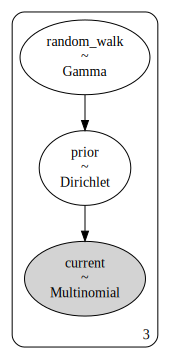

In [122]:
def build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0) -> pm.Model:
    observed = observed.astype("int32")
    with pm.Model() as dirichlet_model:
        rw = pm.Gamma("random_walk",
                      alpha=(rw_alpha_mult * prior),
                      beta=(rw_beta_mult * np.ones(3)), shape=(3,)
                      )
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=rw, shape=(3,),
        )

        pm.Multinomial(
            "current", n=observed.sum(), p=(previous_month_prior), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [123]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

### Weekly update

In [68]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

# df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df_results_weekly = pd.DataFrame({})
# print(df)

for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    
    # model_w = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    model_w = build_model(prior, observed, rw_alpha_mult=15, rw_beta_mult=0.8)
    trace_w, ppc_w = sampling(model_w)
    posterior_w = ppc_w['current']
    
    prior = dirichlet.mle(posterior_w/posterior_w.sum(axis=1).reshape(-1, 1))
    
    qs = calc_prob_lula_win(model_w, trace_w, ppc=ppc_w)
    
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior_w/posterior_w.sum(axis=1).reshape(-1, 1)
    df_results_weekly = df_results_weekly.append(pd.DataFrame({"data":[obj.data_pesquisa],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_weekly

>>> observed = [880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[682.28145807 245.56716981 740.49090942],  qs=[5.7075 6.06   6.52  ]% <<<
lula= [0.38535354 0.40909091 0.43333333]
nulo= [0.13080808 0.1469697  0.16464646]
demais= [0.42020202 0.44393939 0.46717172]
>>> observed = [990.24 288.82 783.94]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-06, updaed_prior=[757.95654811 264.88398608 788.468999  ],  qs=[20.1975 20.94   21.45  ]% <<<
lula= [0.39543911 0.41824357 0.44153324]
nulo= [0.13051917 0.14604561 0.16206938]
demais= [0.41193595 0.43571082 0.45851528]
>>> observed = [ 704.98  270.68 1044.34]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-19, updaed_prior=[716.40513878 253.32058797 777.95755881],  qs=[4.815 5.23  5.625]% <<<
lula= [0.38701685 0.40981169 0.43260654]
nulo= [0.12884044 0.14469772 0.16106293]
demais= [0.42170466 0.44549058 0.46778989]
>>> observed = [ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-20, updaed_prior=[717.69265563 241.07498252 812.28088293],  qs=[0.6075 0.71   0.84  ]% <<<
lula= [0.3815 0.4055 0.429 ]
nulo= [0.12   0.136  0.1525]
demais= [0.4355 0.459  0.482 ]
>>> observed = [ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-24, updaed_prior=[ 866.53129554  283.3784171  1035.15793448],  qs=[0.     0.     0.0325]% <<<
lula= [0.37656566 0.39676768 0.41737374]
nulo= [0.1159596  0.12969697 0.14424242]
demais= [0.45212121 0.47393939 0.49414141]
>>> observed = [1883.628  140.832 2376.54 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-29, updaed_prior=[1474.52410348  404.64762354 1783.37145311],  qs=[0. 0. 0.]% <<<
lula= [0.38645147 0.4025915  0.41804956]
nulo= [0.10047738 0.11047965 0.12070925]
demais= [0.47078882 0.48692885 0.50284155]
>>> observed = [937.02 244.44 855.54]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-05, updaed_prior=[774.85421021 212.19255765 919.54322136],  qs=[0.   0.02 0.05]% <<<
lula= [0.38408644 0.40667976 0.42779961]
nulo= [0.09724951 0.11100196 0.12573674]
demais= [0.46021611 0.48231827 0.50491159]
>>> observed = [444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-09, updaed_prior=[448.35294339 124.75657706 536.28431287],  qs=[0.16  0.23  0.285]% <<<
lula= [0.37666667 0.40416667 0.43333333]
nulo= [0.09416667 0.1125     0.13166667]
demais= [0.45333333 0.48333333 0.5125    ]
>>> observed = [856.856 306.306 838.838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-11, updaed_prior=[688.9642578  201.43206668 795.20605148],  qs=[0.1675 0.26   0.375 ]% <<<
lula= [0.3855 0.409  0.432 ]
nulo= [0.104  0.1195 0.1355]
demais= [0.4485 0.4715 0.496 ]
>>> observed = [ 758.  170. 1072.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[690.31585144 196.0166008  817.5224334 ],  qs=[0.01 0.04 0.09]% <<<
lula= [0.3825 0.405  0.428 ]
nulo= [0.1    0.115  0.1305]
demais= [0.456  0.48   0.5035]
>>> observed = [960.96 280.28 760.76]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[733.4966743  208.87610458 827.12267779],  qs=[0.68   0.86   1.1025]% <<<
lula= [0.3915 0.4145 0.438 ]
nulo= [0.103 0.118 0.133]
demais= [0.444  0.4675 0.4905]
>>> observed = [1759.68  366.6  1539.72]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[1313.99822047  351.05789114 1407.34510297],  qs=[3.1125 3.57   3.755 ]% <<<
lula= [0.41075328 0.42767467 0.44541485]
nulo= [0.10316594 0.1143559  0.12554585]
demais= [0.44076829 0.45796943 0.47543668]
>>> observed = [440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[413.94769623 110.91380445 442.16736342],  qs=[15.29 15.95 16.45]% <<<
lula= [0.3970297  0.42772277 0.45940594]
nulo= [0.0950495  0.11485149 0.13467822]
demais= [0.42475248 0.45742574 0.48811881]
>>> observed = [1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-21, updaed_prior=[ 985.7258485   265.97790446 1091.60190558],  qs=[0.7925 0.93   1.065 ]% <<<
lula= [0.401      0.42066667 0.441     ]
nulo= [0.101      0.11333333 0.12666667]
demais= [0.446      0.466      0.48566667]
>>> observed = [900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-09, updaed_prior=[777.44142613 209.13939663 844.52460806],  qs=[4.3225 4.63   5.02  ]% <<<
lula= [0.40204082 0.4244898  0.44795918]
nulo= [0.1        0.11428571 0.12857143]
demais= [0.4377551  0.46122449 0.48367347]
>>> observed = [440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-12, updaed_prior=[407.12966047 110.25406781 440.78240111],  qs=[11.4725 11.98   12.5   ]% <<<
lula= [0.39313725 0.4245098  0.45686275]
nulo= [0.09509804 0.11470588 0.13531863]
demais= [0.42843137 0.45980392 0.49117647]
>>> observed = [615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-13, updaed_prior=[552.31833011 149.60941001 603.7686027 ],  qs=[6.2875 6.65   7.2725]% <<<
lula= [0.396633   0.42289562 0.45050505]
nulo= [0.0976431  0.11447811 0.13198653]
demais= [0.43501684 0.46262626 0.48888889]
>>> observed = [1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-20, updaed_prior=[1028.50710423  282.08157675 1119.84916186],  qs=[2.1025 2.38   2.5625]% <<<
lula= [0.4037037  0.42323232 0.44309764]
nulo= [0.103367   0.11582492 0.12862795]
demais= [0.44040404 0.46094276 0.48080808]
>>> observed = [ 738.  214. 1048.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-26, updaed_prior=[756.76043782 208.04716552 844.27135598],  qs=[1.2875 1.42   1.6025]% <<<
lula= [0.3955 0.4185 0.4405]
nulo= [0.1005 0.115  0.13  ]
demais= [0.4435 0.467  0.49  ]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.385354,0.409091,0.433333,0.420202,0.443939,0.467172
0,2021-11-06,0.395439,0.418244,0.441533,0.411936,0.435711,0.458515
0,2021-11-19,0.387017,0.409812,0.432607,0.421705,0.445491,0.467790
0,2021-11-20,0.381500,0.405500,0.429000,0.435500,0.459000,0.482000
0,2021-11-24,0.376566,0.396768,0.417374,0.452121,0.473939,0.494141
0,2021-11-29,0.386451,0.402591,0.418050,0.470789,0.486929,0.502842
0,2021-12-05,0.384086,0.406680,0.427800,0.460216,0.482318,0.504912
0,2021-12-09,0.376667,0.404167,0.433333,0.453333,0.483333,0.512500
0,2021-12-11,0.385500,0.409000,0.432000,0.448500,0.471500,0.496000
0,2021-12-13,0.382500,0.405000,0.428000,0.456000,0.480000,0.503500


model = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)

>>> data_pesquisa=2022-01-13, updaed_prior=[483.38778278 128.66210683 523.97315797],  qs=[ 9.25   9.69  10.065]% <<<
lula= [0.396633   0.42558923 0.45454545]
nulo= [0.0956229  0.11313131 0.13265993]
demais= [0.43164983 0.46127946 0.49158249]

>>> data_pesquisa=2022-01-20, updaed_prior=[896.11772754 245.53127403 967.04329633],  qs=[4.64 4.95 5.32]% <<<
lula= [0.4037037  0.42491582 0.44612795]
nulo= [0.1030303  0.11649832 0.13030303]
demais= [0.43737374 0.45858586 0.47979798]

In [69]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [70]:
az.summary(trace_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],19166.290,157.626,18876.936,19467.555,2.986,2.112,2783.0,2265.0,1.0
random_walk[1],5265.020,80.057,5117.991,5411.072,1.718,1.215,2167.0,2731.0,1.0
random_walk[2],21140.051,163.985,20818.459,21433.209,2.702,1.911,3681.0,2779.0,1.0
prior[0],0.418,0.003,0.412,0.424,0.000,0.000,2556.0,3092.0,1.0
prior[1],0.115,0.002,0.111,0.119,0.000,0.000,1727.0,2362.0,1.0
prior[2],0.466,0.003,0.460,0.473,0.000,0.000,3782.0,3031.0,1.0


In [71]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula_w = ppc_w['current'][:,0] / ppc_w['current'].sum(axis=1) * 100
nulo_w = ppc_w['current'][:,1] / ppc_w['current'].sum(axis=1) * 100.00
demais_w = ppc_w['current'][:,2] / ppc_w['current'].sum(axis=1) * 100
# az.plot_posterior({'Lula': lula, 'Demais': demais});
# az.plot_posterior({}, ax=ax[1])

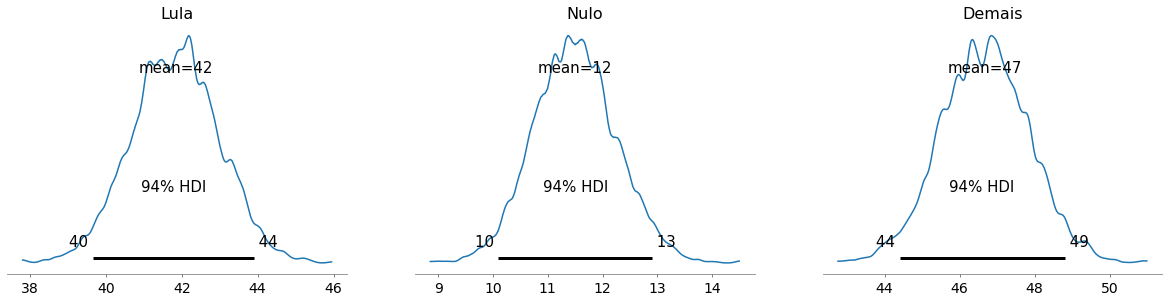

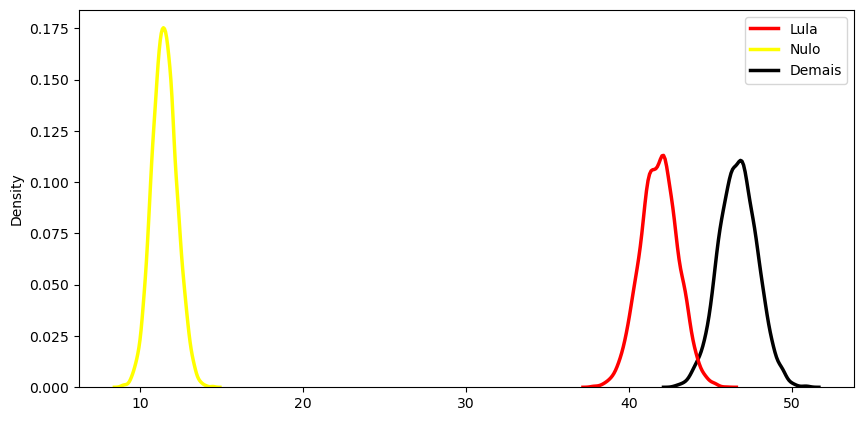

In [72]:
# a0 = np.array([100, 299, 100])
# D0 = np.random.dirichlet(a0, 1000)
# D0
post_pred_w = pd.DataFrame({'Lula': lula_w, 'Nulo': nulo_w, 'Demais': demais_w})
az.plot_posterior(post_pred_w.to_dict(orient='list'));
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)

sns.kdeplot(data=post_pred_w, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=100);

In [73]:
df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.385354,0.409091,0.433333,0.420202,0.443939,0.467172
0,2021-11-06,0.395439,0.418244,0.441533,0.411936,0.435711,0.458515
0,2021-11-19,0.387017,0.409812,0.432607,0.421705,0.445491,0.467790
0,2021-11-20,0.381500,0.405500,0.429000,0.435500,0.459000,0.482000
0,2021-11-24,0.376566,0.396768,0.417374,0.452121,0.473939,0.494141
0,2021-11-29,0.386451,0.402591,0.418050,0.470789,0.486929,0.502842
0,2021-12-05,0.384086,0.406680,0.427800,0.460216,0.482318,0.504912
0,2021-12-09,0.376667,0.404167,0.433333,0.453333,0.483333,0.512500
0,2021-12-11,0.385500,0.409000,0.432000,0.448500,0.471500,0.496000
0,2021-12-13,0.382500,0.405000,0.428000,0.456000,0.480000,0.503500


## MONTHLY

In [74]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048.848 1507.332 7382.82 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3054.74093377  767.85130405 3713.12008762],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39418893 0.40536922 0.41648423]
nulo= [0.09513289 0.10189462 0.10879025]
demais= [0.48168809 0.49273616 0.50371561]
>>> observed = [7356.516 1973.626 7586.858]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[3985.37246449 1057.18461694 4235.85382019],  qs=['0.2%', '0.3%', '0.3975%'] <<<
lula= [0.41945019 0.42950044 0.43990541]
nulo= [0.10747857 0.11398167 0.12048478]
demais= [0.4462888  0.45651788 0.46639226]
>>> observed = [3953. 1109. 4373.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2368.64023767  652.0417896  2586.3178673 ],  qs=['0.03%', '0.09%', '0.13749999999999998%'] <<<
lula= [0.40975093 0.42257552 0.43550874]
nulo= [0.10789613 0.11626921 0.12496025]
demais= [0.44811871 0.46115527 0.47419184]


model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [75]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],3953.093,56.614,3850.483,4064.055,0.958,0.677,3517.0,2882.0,1.0
random_walk[1],1068.129,27.794,1016.884,1121.093,0.502,0.355,3070.0,2790.0,1.0
random_walk[2],4258.251,59.169,4146.732,4367.766,0.984,0.696,3621.0,3111.0,1.0
prior[0],0.422,0.004,0.415,0.431,0.000,0.000,3092.0,3111.0,1.0
prior[1],0.116,0.003,0.112,0.122,0.000,0.000,2803.0,2866.0,1.0
prior[2],0.461,0.004,0.453,0.469,0.000,0.000,4473.0,3329.0,1.0


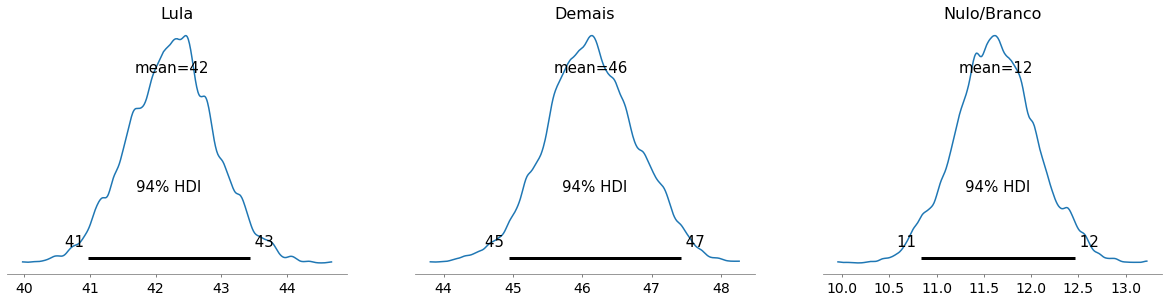

In [76]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

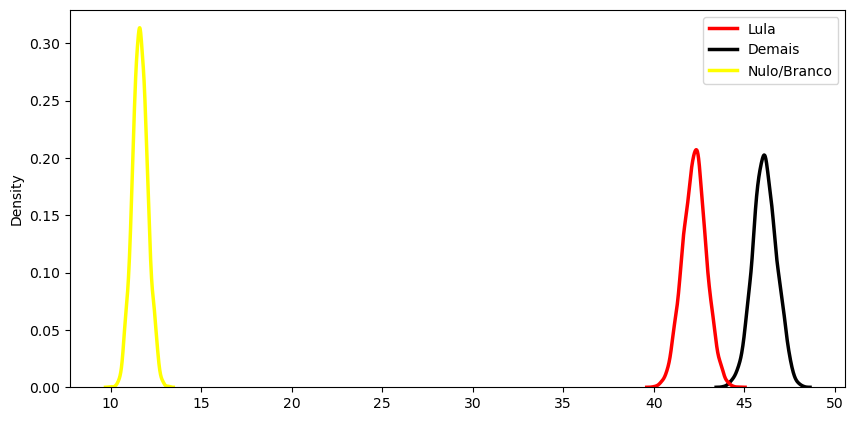

In [77]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [78]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.0008

## Playground

In [79]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

0.32736042300928847

In [80]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [81]:
observed.sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [82]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

# df_gm = px.data.gapminder()
# px.scatter(df_gm, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [83]:
# hide_input
# This cell is required for the export to HTML to work.


In [84]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

[[0.51061213 0.10232741 0.38706046]
 [0.3951909  0.054262   0.5505471 ]
 [0.37102092 0.14799003 0.48098905]
 [0.48886284 0.09279697 0.4183402 ]]


In [85]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


0.43625
(4000, 3)


In [86]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [87]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

[1223.86606598 1260.74042882 1163.06695847 ... 1221.37582506 1198.07889137
 1212.00685358]
[682.68842437 525.99908766 493.82883863 615.47831307 662.51134272
 568.16216448 648.00904949 631.91822695 649.72775083 568.436377  ]
[504.3397744  714.61014042 609.89411632 550.53569895 511.09244206
 595.79518669 551.73292491 511.77325016 549.32855419 582.70392125]


In [88]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

0.51975


In [89]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [90]:
dir2

array([[0.55432095, 0.04579972, 0.39987933],
       [0.48832295, 0.03328908, 0.47838797],
       [0.47799335, 0.03523928, 0.48676737],
       ...,
       [0.511237  , 0.03498016, 0.45378284],
       [0.52941967, 0.03348722, 0.43709311],
       [0.52231374, 0.02157467, 0.45611159]])

In [91]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

0.504


In [92]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [93]:
np.linspace(0,1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [94]:
x = np.arange(5,10)

In [95]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

array([ 0,  5,  6,  7,  8,  9, 14])

In [96]:
1.96 * np.sqrt((0.5**2)/3000)

0.017892270211835426

In [97]:
1./(1./0.01789 + 1./0.0200)

0.009443124835048826

In [98]:
1/100

0.01

In [99]:
1/(1./0.01789 + 1./0.0200)

0.009443124835048826

In [100]:
X = np.arange(1, 100)
X.mean(), X.std()

(50.0, 28.577380332470412)

20.39453534909155 4.421935907014502


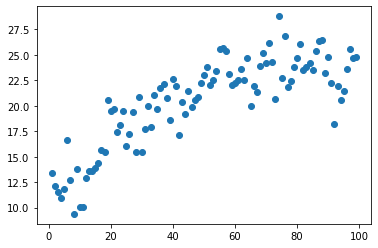

In [101]:
Y = 12*(np.sin(X/50) + 1) + np.random.normal(0, 2, X.size)
print(Y.mean(), Y.std())
plt.scatter(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


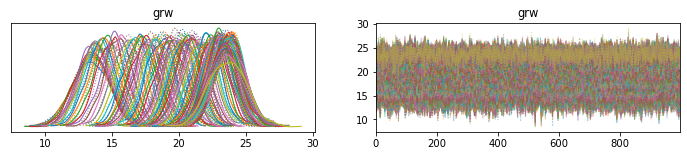

In [102]:
with pm.Model() as grw:
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=0.5, shape=X.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=Y.std(), observed=Y)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [103]:
trace.posterior.grw.mean(axis=0).mean(axis=0)

<xarray.DataArray 'grw' (grw_dim_0: 99)>
array([13.43649353, 13.42616556, 13.4225122 , 13.46460091, 13.55031981,
       13.63518278, 13.70380914, 13.77179822, 13.88000141, 14.00966734,
       14.17242639, 14.39612188, 14.64789593, 14.90144233, 15.16628483,
       15.4570348 , 15.76418916, 16.07820885, 16.40025629, 16.67418878,
       16.90028282, 17.08507992, 17.26508605, 17.43599697, 17.5862444 ,
       17.77015222, 17.94854217, 18.11735426, 18.29162675, 18.46029584,
       18.65809631, 18.88730419, 19.10490989, 19.30054234, 19.51475448,
       19.70630359, 19.87510022, 20.01252309, 20.1547198 , 20.29527061,
       20.39623235, 20.49237039, 20.63380369, 20.77347195, 20.9362429 ,
       21.10518427, 21.28574   , 21.47057832, 21.65784698, 21.84983884,
       22.02557364, 22.1736855 , 22.31796035, 22.48404186, 22.62899428,
       22.73145466, 22.79900582, 22.82885265, 22.86191451, 22.89712747,
       22.93971991, 22.99692436, 23.03486297, 23.08261995, 23.12411774,
       23.18140818, 23.26194612, 23.36783384, 23.4649037 , 23.55034071,
       23.63820511, 23.68587677, 23.70253075, 23.76384584, 23.77609556,
       23.79989992, 23.78657825, 23.79078797, 23.82318982, 23.85175309,
       23.87746818, 23.8670398 , 23.83262033, 23.82054965, 23.81568928,
       23.807648  , 23.7785671 , 23.74307363, 23.67096811, 23.5936479 ,
       23.48399214, 23.41467047, 23.36404905, 23.37099697, 23.41187665,
       23.48305858, 23.53305319, 23.56576134, 23.57678903])
Coordinates:
  * grw_dim_0  (grw_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

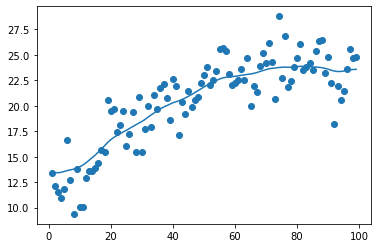

In [104]:
plt.scatter(X, Y)
plt.plot(X, trace.posterior.grw.mean(axis=0).mean(axis=0))

In [105]:
# az.summary(trace)
trace.posterior.grw.mean(axis=0).shape

(1000, 99)

In [106]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)


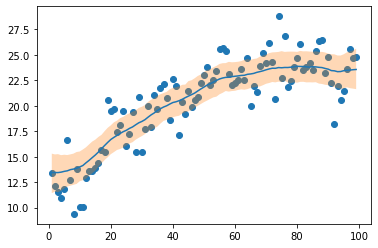

In [107]:
plt.scatter(X, Y)
plt.plot(X, qs[1])
plt.fill_between(x=X,y1=qs[0], y2=qs[2], alpha=0.3)

In [108]:
df.shape

(19, 7)

In [153]:
YL = raw_df.query("partido == 'PT' ")["percentual"]
YL = YL.append(to_append=pd.Series([42, 36.9]))
#YL = YL.append(to_append=pd.Series([np.nan]*10))

XL = np.arange(YL.size)
# XL = df_results_weekly.data
# YL = YL.append(to_append=pd.Series([42]))
# YL[10:13]=np.nan

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.


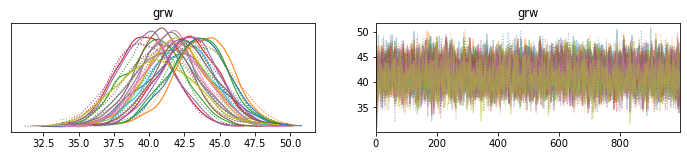

In [162]:
with pm.Model() as grw:
    
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=2.0, shape=XL.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=YL.std(), observed=YL)
    
    trace = pm.sample(1000, tune=500, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


   data_pesquisa       LULA         LB          M         UB
0     2021-11-04  44.444444  38.466307  42.066401  46.033083
1     2021-11-06  48.000000  38.552986  41.821774  44.925552
2     2021-11-19  34.900000  37.471761  40.105271  43.161514
3     2021-11-20  37.000000  36.930973  39.624158  42.354933
4     2021-11-24  34.343434  36.786958  39.615549  42.447322
5     2021-11-29  42.800000  37.895652  40.740281  43.625312
6     2021-12-05  46.000000  38.477736  41.434028  44.442660
7     2021-12-09  37.000000  38.250816  41.245015  44.336199
8     2021-12-11  42.800000  38.924618  41.869392  44.699384
9     2021-12-13  42.950000  39.773636  42.856911  45.670932
10    2021-12-16  45.782178  40.722140  43.594411  46.641604
11    2021-12-21  40.000000  39.793505  42.762276  45.685466
12    2022-01-09  45.918367  39.879712  42.860944  45.983699
13    2022-01-12  43.137255  39.364131  42.458643  45.380658
14    2022-01-13  41.414141  38.701078  41.681894  44.720361
15    2022-01-20  42.000

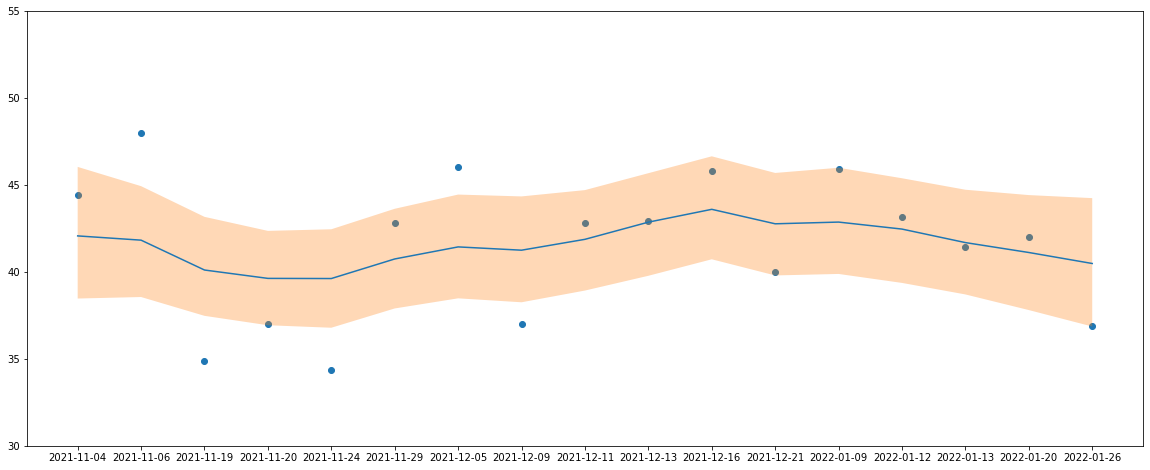

In [163]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs)
df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0], 'M':qs[1], 'UB':qs[2]})
# print(df_rand_walk)
table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
table_rw.columns = table_rw.columns.to_flat_index()
print(table_rw)

plt.figure(figsize=(20,8))
plt.ylim(30, 55)

plt.scatter(table_rw.data_pesquisa, table_rw.LULA)
plt.plot(table_rw.data_pesquisa, table_rw.M)
plt.fill_between(x=table_rw.data_pesquisa, y1=table_rw.LB, y2=table_rw.UB, alpha=0.3)

In [169]:
df_results_weekly['LULA'] = df.LULA.values
df_results_weekly['DEMAIS'] = df.OUTROS.values
df_results_weekly['TOTAL'] = df.TOTAL.values

df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB,LULA,DEMAIS,TOTAL
0,2021-11-04,0.385354,0.409091,0.433333,0.420202,0.443939,0.467172,880.000,660.000,1980.0
0,2021-11-06,0.395439,0.418244,0.441533,0.411936,0.435711,0.458515,990.240,783.940,2063.0
0,2021-11-19,0.387017,0.409812,0.432607,0.421705,0.445491,0.467790,704.980,1044.340,2020.0
0,2021-11-20,0.381500,0.405500,0.429000,0.435500,0.459000,0.482000,740.000,1118.000,2000.0
0,2021-11-24,0.376566,0.396768,0.417374,0.452121,0.473939,0.494141,850.000,1400.000,2475.0
0,2021-11-29,0.386451,0.402591,0.418050,0.470789,0.486929,0.502842,1883.628,2376.540,4401.0
0,2021-12-05,0.384086,0.406680,0.427800,0.460216,0.482318,0.504912,937.020,855.540,2037.0
0,2021-12-09,0.376667,0.404167,0.433333,0.453333,0.483333,0.512500,444.000,600.000,1200.0
0,2021-12-11,0.385500,0.409000,0.432000,0.448500,0.471500,0.496000,856.856,838.838,2002.0
0,2021-12-13,0.382500,0.405000,0.428000,0.456000,0.480000,0.503500,758.000,1072.000,2000.0


In [140]:
# YL = YL/100.0
# dfrw.data.values[-1]


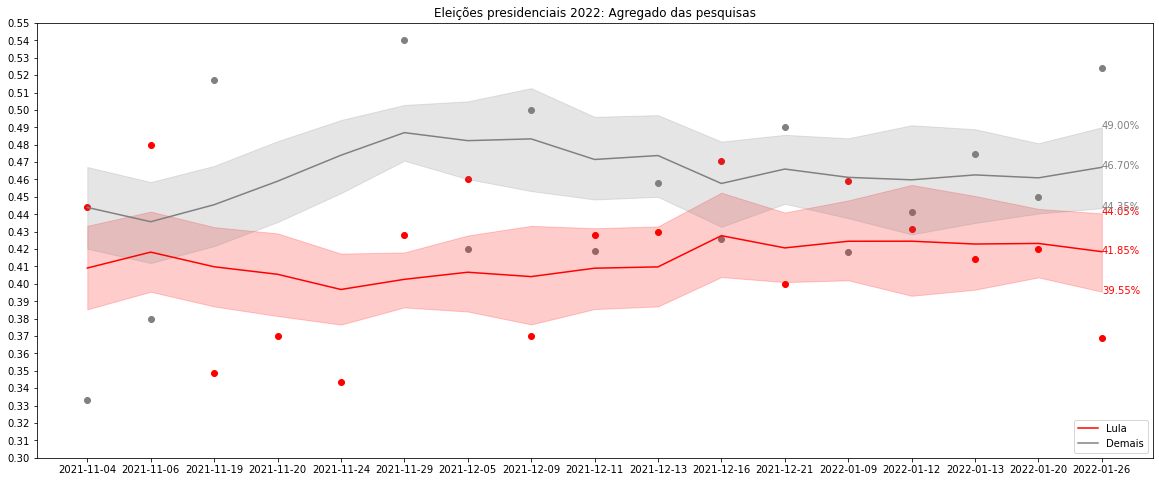

In [181]:
dfrw = df_results_weekly.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.55)
plt.yticks(np.arange(0.30, 0.55, 0.01))

plt.scatter(dfrw.data, dfrw.LULA/dfrw.TOTAL, color='red')
plt.scatter(dfrw.data, dfrw["DEMAIS"]/dfrw["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

In [142]:
new_df = df.shift(1).copy()
new_df.loc[0,:] = np.array([100,100,100,100,100,100,100])
new_df


,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,100,100,100.000,100.000,100.000,100.0,100
1,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
2,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
3,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
4,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
5,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
6,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
7,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
8,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
9,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12


## Modelo diário